In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
## Tire horizontal force calculation
def HorF(f_z_fl, f_z_fr, f_z_rl, f_z_rr,alpha, Ax, deltaW): # Horizontal Force
    ### tire parameters
    # c_roll:                       [-] rolling resistance coefficient
    # f_z0:                         [N] nominal normal force
    # B_front:                      [-] Coefficient B for front tire
    # C_front:                      [-] Coefficient C for front tire
    # eps_front:                    [-] load dependence of Coefficient D for front tire
    # E_front:                      [-] Coefficient E for front tire
    # B_rear:                       [-] Coefficient B for rear tire
    # C_rear:                       [-] Coefficient C for rear tire
    # eps_rear:                     [-] load dependence of Coefficient D for rear tire
    # E_rear:                       [-] Coefficient E for rear tire
    # Hint: The D parameter of the Magic Formula is determined by D = F_z * mue. mue can be set above in optim_opts_mintime!
    tire = {"c_roll": 0.013,
            "f_z0": 4000.0,
            "B_front": 8.0,
            "C_front": 2.5,
            "eps_front": -0.1,
            "E_front": 1.0,
            "B_rear": 10.0,
            "C_rear": 2.5,
            "eps_rear": -0.1,
            "E_rear": 1.0}
    vehmass = 1600
    brakebias = 0.65
    g = 9.81
    # TLLTD
    
    # longitudinal tire forces [N]
    if Ax >= 0: # RWD
        f_x_rl = 0.5 * Ax * g * vehmass
        if f_x_rl >= f_z_rl:
            f_x_rl = f_z_rl
        f_x_rr = 0.5 * Ax * g * vehmass
        if f_x_rr >= f_z_rr:
            f_x_rr = f_z_rr
        f_x_rl = min(f_x_rl, f_x_rr)
        f_x_rr = min(f_x_rl, f_x_rr)
        mu_rl = np.sqrt((f_z_rl)**2 - (f_x_rl)**2) / f_z_rl
        mu_rr = np.sqrt((f_z_rr)**2 - (f_x_rr)**2) / f_z_rr
        f_x_fl = 0
        f_x_fr = 0
        mu_fl = 1
        mu_fr = 1
        
    if Ax < 0: ## Braking
        f_x_rl = 0.5 * Ax * g * vehmass * (1-brakebias)
        if abs(f_x_rl) >= f_z_rl:
            mu_rl = 0
            f_x_rl = -f_z_rl
        else:  mu_rl = np.sqrt((f_z_rl)**2 - (f_x_rl)**2) / f_z_rl
        f_x_rr = 0.5 * Ax * g * vehmass * (1-brakebias)
        if abs(f_x_rr) >= f_z_rr:
            mu_rr = 0
            f_x_rr = -f_z_rr
        else: mu_rr = np.sqrt((f_z_rr)**2 - (f_x_rr)**2) / f_z_rr
        f_x_fl = 0.5 * Ax * g * vehmass * brakebias
        if abs(f_x_fl) >= f_z_fl:
            mu_fl = 0
            f_x_fl = -f_z_fl
        else:  mu_fl = np.sqrt((f_z_fl)**2 - (f_x_fl)**2) / f_z_fl
        f_x_fr = 0.5 * Ax * g * vehmass * brakebias
        if abs(f_x_fr) >= f_z_fr:
            mu_fr = 0
            f_x_fr = -f_z_fr
        else: mu_fr = np.sqrt((f_z_fr)**2 - (f_x_fr)**2) / f_z_fr
            
   
    
    # lateral tire forces [N]
    f_y_fl = (1.1*mu_fl * f_z_fl * (1 + tire["eps_front"] * f_z_fl / tire["f_z0"])
              * math.sin(tire["C_front"] * math.atan(tire["B_front"] * alpha[0] - tire["E_front"]
                                                 * (tire["B_front"] * alpha[0] - math.atan(tire["B_front"] * alpha[0])))))
    f_y_fr = (1.1*mu_fr * f_z_fr * (1 + tire["eps_front"] * f_z_fr / tire["f_z0"])
              * math.sin(tire["C_front"] * math.atan(tire["B_front"] * alpha[1] - tire["E_front"]
                                                 * (tire["B_front"] * alpha[1] - math.atan(tire["B_front"] * alpha[1])))))
    f_y_rl = (1.1*mu_rl * f_z_rl * (1 + tire["eps_rear"] * f_z_rl / tire["f_z0"])
              * math.sin(tire["C_rear"] * math.atan(tire["B_rear"] * alpha[2] - tire["E_rear"]
                                                * (tire["B_rear"] * alpha[2] - math.atan(tire["B_rear"] * alpha[2])))))
    f_y_rr = (1.1*mu_rr * f_z_rr * (1 + tire["eps_rear"] * f_z_rr / tire["f_z0"])
              * math.sin(tire["C_rear"] * math.atan(tire["B_rear"] * alpha[3] - tire["E_rear"]
                                                * (tire["B_rear"] * alpha[3] - math.atan(tire["B_rear"] * alpha[3])))))
    # Total Fx
    Fx =(f_x_fl + f_x_fr) * math.cos(deltaW) + f_x_rl + f_x_rr + (-f_y_fl - f_y_fr) * math.sin(deltaW)
    
    # Total Fy
    Fy = (f_y_fl + f_y_fr) * math.cos(deltaW) + f_y_rl + f_y_rr + (-f_x_fl - f_x_fr) * math.sin(deltaW)    
    
    return [[f_x_fl, f_x_fr, f_x_rl, f_x_rr], [f_y_fl, f_y_fr, f_y_rl, f_y_rr], Fx, Fy]


## Wheel loads after lateral load transfer
def llt(vehPars: dict, deltaW, fy: list, fx:list):
    g = 9.81
    # Total Fx
    Fx =(fx[0] + fx[1]) * math.cos(deltaW) + fx[2] + fx[3] + (-fy[0] - fy[1]) * math.sin(deltaW)
    
    # Total Fy
    Fy = (fy[0] + fy[1]) * math.cos(deltaW) + fy[2] + fy[3] + (-fx[0] - fx[1]) * math.sin(deltaW)
    
    #   Load Transfer Model
    # static normal tire forces [N]
    f_zstat_fl = 0.5 * vehPars["mass"] * g * vehPars["l_rear"] / vehPars["WB"]
    f_zstat_fr = 0.5 * vehPars["mass"] * g * vehPars["l_rear"] / vehPars["WB"]
    f_zstat_rl = 0.5 * vehPars["mass"] * g * vehPars["l_front"] / vehPars["WB"]
    f_zstat_rr = 0.5 * vehPars["mass"] * g * vehPars["l_front"] / vehPars["WB"]

#     # dynamic normal tire forces (aerodynamic downforces) [N]
#     f_zlift_fl = 0.5 * veh["liftcoeff_front"] * v ** 2
#     f_zlift_fr = 0.5 * veh["liftcoeff_front"] * v ** 2
#     f_zlift_rl = 0.5 * veh["liftcoeff_rear"] * v ** 2
#     f_zlift_rr = 0.5 * veh["liftcoeff_rear"] * v ** 2

    # dynamic normal tire forces (load transfers) [N]
    f_zdyn_fl = vehPars["CG_Height"] * (-0.5 / vehPars["WB"] * Fx - vehPars["k_roll"] * Fy / vehPars["TrackWidth_f"])
    f_zdyn_fr = vehPars["CG_Height"] * (-0.5 / vehPars["WB"] * Fx + vehPars["k_roll"] * Fy / vehPars["TrackWidth_f"])
    f_zdyn_rl = vehPars["CG_Height"] * ( 0.5 / vehPars["WB"] * Fx - (1.0 - vehPars["k_roll"]) * Fy / vehPars["TrackWidth_r"])
    f_zdyn_rr = vehPars["CG_Height"] * ( 0.5 / vehPars["WB"] * Fx + (1.0 - vehPars["k_roll"]) * Fy / vehPars["TrackWidth_r"])

    # sum of all normal tire forces [N]
    f_z_fl = f_zstat_fl + f_zdyn_fl
    f_z_fr = f_zstat_fr + f_zdyn_fr
    f_z_rl = f_zstat_rl + f_zdyn_rl
    f_z_rr = f_zstat_rr + f_zdyn_rr
    
    return [f_z_fl, f_z_fr, f_z_rl, f_z_rr]

## Kinematics 
def slipangle(deltaW, u, v, vehPars: dict, omega_z):
    alpha[0] = deltaW - math.atan((v + vehPars["l_front"] * omega_z) /
                                   (u - 0.5 * vehPars["TrackWidth_f"] * omega_z))
    alpha[1] = deltaW - math.atan((v + vehPars["l_front"] * omega_z) /
                                   (u + 0.5 * vehPars["TrackWidth_f"] * omega_z))
    alpha[2] = math.atan((-v + vehPars["l_rear"] * omega_z) /
                           (u - 0.5 *vehPars["TrackWidth_r"] * omega_z))
    alpha[3] = math.atan((-v + vehPars["l_rear"] * omega_z) /
                           (u + 0.5 * vehPars["TrackWidth_r"] * omega_z))
#     alpha[0] = deltaW - math.atan((u * math.sin(beta) + vehPars["l_front"] * omega_z) /
#                                    (u * math.cos(beta) - 0.5 * vehPars["TrackWidth_f"] * omega_z))
#     alpha[1] = deltaW - math.atan((u * math.sin(beta) + vehPars["l_front"] * omega_z) /
#                                    (u * math.cos(beta) + 0.5 * vehPars["TrackWidth_f"] * omega_z))
#     alpha[2] = math.atan((-u * beta + vehPars["l_rear"] * omega_z) /
#                            (u - 0.5 *vehPars["TrackWidth_r"] * omega_z))
#     alpha[3] = math.atan((-u * beta + vehPars["l_rear"] * omega_z) /
#                            (u + 0.5 * vehPars["TrackWidth_r"] * omega_z))
    return alpha

In [5]:
# Vehicle parameters
vehPars = {"mass": 1600,
           "l_front": 1.15,
           "l_rear": 1.55,
           "WB": 2.7,
           "Jz": 3000,
           "TrackWidth_f": 1.6,
           "TrackWidth_r": 1.6,
           "CG_Height": 0.5,
           "RCH": 0.3,
           "k_roll":0.65}   # TLLTD


In [7]:
# System dynamics 
def fdot(Xk,Uk,V,vehPars: dict):
    X_dot = np.zeros([4, 1])
## Vehicle parameters
#     Kf = 40000    # Cornering stiffness front
#     Kr = 60000    # Cornering stiffness rear
#     m = 1600      # Total mass
#     l = 2.7       # Wheel base
#     lf = 1.05     # CoG distance to front axle
#     Jz = 3000     # Yaw moment of inertia
#     mu = 1
#     g = 9.81
    Fz = np.zeros(4)
    u = V        # Forward speed
    Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
    Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
    Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
    Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
    
    alpha = slipangle(Uk, u, Xk[0], vehPars, Xk[1])
#     print("alpha_rl = ", alpha[2]*180/np.pi)
    FxFy = HorF(Fz[0], Fz[1], Fz[2], Fz[3],alpha, 0, Uk)
    Fx = FxFy[0]
    Fy = FxFy[1]
    # Non-linear tire characteristics
#     Fy = (fy[0] + fy[1]) * math.cos(deltaW) + fy[2] + fy[3] + (-fx[0] - fx[1]) * math.sin(deltaW)
#     Ff = Kf * (Uk - (Xk[1] * lf + Xk[0])/V)
#     Fr = Kr * (Xk[1] * (l - lf) - Xk[0])/V
    Ff = Fy[0] + Fy[1]
    Fr = Fy[2] + Fy[3]
    
    # Update wheel loads
#     Fz = llt(vehPars, Uk, Fy, Fx)
    
    # derivatives
    X_dot[0:1] = (1/vehPars["mass"] * (Xk[2] + Xk[3])) - u*Xk[1]       # Derivative of lateral velocity(v_dot)
    X_dot[1:2] = 1/vehPars["Jz"]*(Xk[2]*vehPars["l_front"] - Xk[3]*vehPars["l_rear"]) # Derivative of lateral velocity yaw rate (phi_dot)
    X_dot[2:3] = vehPars["sigma_f"] * (Ff - Xk[2]) # Force dynamics lateral front (PT-1)
    X_dot[3:4] = 10 * (Fr - Xk[3]) # Force dynamics lateral rear (PT-1)
#     print(Ff)    
    return X_dot

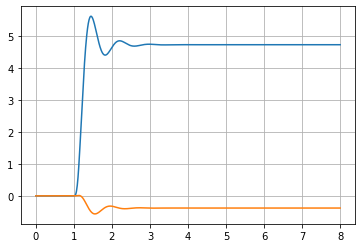

In [9]:
vehPars = {"mass": 1600,
           "l_front": 1.35,
           "l_rear": 1.35,
           "WB": 2.7,
           "Jz": 3000,
           "TrackWidth_f": 1.6,
           "TrackWidth_r": 1.6,
           "CG_Height": 0.5,
           "RCH": 0.3,
           "k_roll":0.65,
           "sigma_f": 10}   # TLLTD
V = 30
##simulation
time = 8 # [s]
dt = 0.01
N = int(time/dt)
X = np.zeros([4, N+1])
U = np.zeros(N+1)
Fy = np.zeros(4)
Fz = np.zeros(4)
alpha = np.zeros(4)
X[:,0] = [0,0,0,0]
max_U = 0.01    # [rad] SS front wheel angle
strt_U = 1     # [s] Start of steering action
rate_U = 0.1   # [rad/s]Rate of steering action
Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
NU = int(strt_U/dt+1)
temp = 0
pha = 0
for i in range(N-NU):
## sine wave #####################################
#     pha = pha + 0.5*np.pi*dt
#     temp = 0.01*math.sin(pha) 
#     U[i + NU] = temp
##################################################

## Step steer#####################################
    temp = temp + dt*rate_U
    U[i + NU] = temp
    if temp > max_U:
        U[i + NU:] = max_U
        break
#################################################        
        
## Impulse Steer #################################
#     pha = pha + 2*np.pi*dt
#     temp = 0.03*math.sin(pha)
#     U[i + NU] = temp
#     if i >= 0.5/dt:
#         U[i + NU:] = 0
#         break
##################################################

## Integration RK4
for i in range(N):
    Xk = X[:,i:i+1]
    Uk = U[i]
    k1 = fdot(Xk,Uk,V, vehPars)
#     print(k1)
    k2 = fdot(Xk+ k1 * dt/2,Uk, V, vehPars)
    k3 = fdot(Xk+ k2 * dt/2,Uk, V, vehPars)
    k4 = fdot(Xk+ k3 * dt,Uk, V, vehPars)
    X[:,i+1:i+2] = Xk + (k1 + 2*k2 + 2*k3 + k4)*dt/6
# plt.plot(np.linspace(0, time, num=N+1),U*180/np.pi*15)
plt.plot(np.linspace(0, time, num=N+1),X[1,:]*180/np.pi) # yaw rate
plt.plot(np.linspace(0, time, num=N+1),X[0,:]/V*180/np.pi) # side slip angle
plt.grid()

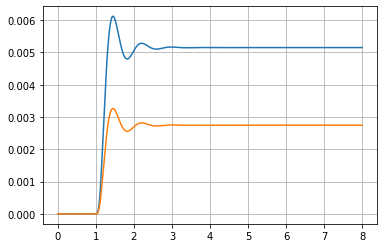

In [10]:
# 
plt.plot(np.linspace(0, time, num=N+1),X[1,:]*vehPars["Jz"]/(30*vehPars["mass"])) # 
plt.plot(np.linspace(0, time, num=N+1),X[1,:]/V) # turning radius
plt.grid()

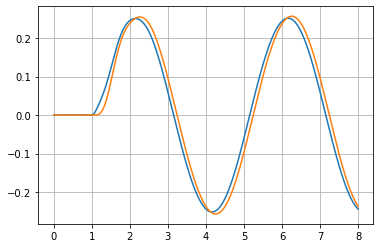

In [19]:
plt.plot(np.linspace(0, time, num=N+1),X[2,:]/(Fz[0] + Fz[1]))
plt.plot(np.linspace(0, time, num=N+1),X[3,:]/(Fz[2] + Fz[3]))
# plt.plot(np.linspace(0, time, num=N+1),U)
plt.grid()

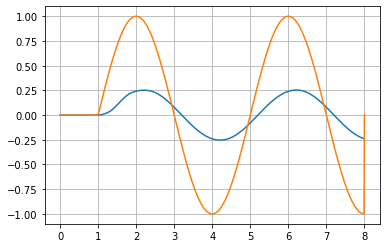

In [21]:
plt.plot(np.linspace(0, time, num=N+1),(X[2,:]+X[3,:])/(sum(Fz)))
plt.plot(np.linspace(0, time, num=N+1),U/0.01)
# plt.plot(np.linspace(0, time, num=N+1),U)
plt.grid()

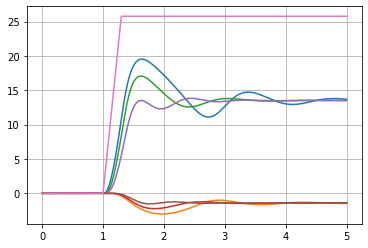

In [13]:
## Checking transient effects of relaxation length
V = 30
for sig_f in [0.5, 2, 5]:
    vehPars = {"mass": 1600,
           "l_front": 1.35,
           "l_rear": 1.35,
           "WB": 2.7,
           "Jz": 3000,
           "TrackWidth_f": 1.6,
           "TrackWidth_r": 1.6,
           "CG_Height": 0.5,
           "RCH": 0.3,
           "k_roll":0.65,
           "sigma_f": V/sig_f}   # TLLTD
    ##simulation
    time = 5 # [s]
    dt = 0.01
    N = int(time/dt)
    X = np.zeros([4, N+1])
    U = np.zeros(N+1)
    Fy = np.zeros(4)
    Fz = np.zeros(4)
    alpha = np.zeros(4)
    X[:,0] = [0,0,0,0]
    max_U = 0.03    # [rad] SS front wheel angle
    strt_U = 1     # [s] Start of steering action
    rate_U = 0.1   # [rad/s]Rate of steering action
    Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
    Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
    Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
    Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
    NU = int(strt_U/dt+1)
    temp = 0
    pha = 0
    for i in range(N-NU):
    ## sine wave #####################################
#         pha = pha + 0.5*np.pi*dt
#         temp = 0.03*math.sin(pha) 
#         U[i + NU] = temp
    ##################################################

    ## Step steer#####################################
        temp = temp + dt*rate_U
        U[i + NU] = temp
        if temp > max_U:
            U[i + NU:] = max_U
            break
    ##################################################        

    ## Impulse Steer #################################
    #     pha = pha + 2*np.pi*dt
    #     temp = 0.03*math.sin(pha)
    #     U[i + NU] = temp
    #     if i >= 0.5/dt:
    #         U[i + NU:] = 0
    #         break
    ##################################################

    ## Integration RK4
    for i in range(N):
        Xk = X[:,i:i+1]
        Uk = U[i]
        k1 = fdot(Xk,Uk,V, vehPars)
    #     print(k1)
        k2 = fdot(Xk+ k1 * dt/2,Uk,V, vehPars)
        k3 = fdot(Xk+ k2 * dt/2,Uk,V, vehPars)
        k4 = fdot(Xk+ k3 * dt,Uk,V, vehPars)
        X[:,i+1:i+2] = Xk + (k1 + 2*k2 + 2*k3 + k4)*dt/6
    
    plt.plot(np.linspace(0, time, num=N+1),X[1,:]*180/np.pi)
    plt.plot(np.linspace(0, time, num=N+1),X[0,:]/30*180/np.pi)
plt.plot(np.linspace(0, time, num=N+1),U*180/np.pi*15)
plt.grid()

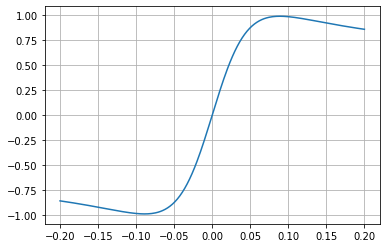

In [11]:
# Check MF
Fz[0] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
Fz[1] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_rear"] / vehPars["WB"]
Fz[2] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
Fz[3] = 0.5 * vehPars["mass"] * 9.81 * vehPars["l_front"] / vehPars["WB"]
for Ax in [0]:
    F = []
    for alpha in np.linspace(-0.2, 0.2, num=250):
        F.append(HorF(Fz[0], Fz[1], Fz[2], Fz[3],[alpha, alpha, alpha, alpha],Ax,0)[1][2])
    plt.plot(np.linspace(-0.2, 0.2, num=250), F/Fz[2])
plt.grid()